In [101]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from scipy.stats import spearmanr

In [102]:
class ProxyDataset:
    def __init__(self, proxy_dataset_path: os.PathLike):
        self.proxy_df = None
        self.proxy_dataset_path = proxy_dataset_path
        self.proxy_dataset = pq.ParquetDataset(proxy_dataset_path)

    def load(self, columns: list = None):
        self.proxy_df = self.proxy_dataset.read(columns=columns).to_pandas()

        return self.proxy_df

    def calculate_proxy_score_per_epoch(self, epoch: int, proxy_name: str):
        return self.proxy_df.loc[self.proxy_df['epoch'] == epoch, proxy_name].mean()

In [103]:
proxy_dataset = ProxyDataset("../models/proxies/cifar100-proxy-20230420_0900")

proxy_df = proxy_dataset.load()

proxy_df["epoch"] = proxy_df["epoch"].astype(int)

proxy_df.sort_values(by=["epoch", "sample_indices"], inplace=True)

In [104]:
def calculate_proxy_score_per_epoch(proxy_df: pd.DataFrame, proxy_name: str):
    return proxy_df.groupby(["sample_indices"]).agg({proxy_name: "cumsum"})

In [105]:
proxy_df["p_L_cs"] = calculate_proxy_score_per_epoch(proxy_df, "p_L")
proxy_df["p_max_cs"] = calculate_proxy_score_per_epoch(proxy_df, "p_max")
proxy_df["H_cs"] = calculate_proxy_score_per_epoch(proxy_df, "H")
proxy_df["loss_cs"] = calculate_proxy_score_per_epoch(proxy_df, "loss")

In [106]:
proxy_df

,y,sample_indices,correctly_predicted,p_L,p_max,H,epoch,p_L_cs,p_max_cs,H_cs
7969,19,0,False,0.009132,0.011559,4.601562,0,0.009132,0.011559,4.601562
41897,29,1,False,0.009872,0.011864,4.597656,0,0.009872,0.011864,4.597656
38101,0,2,False,0.008224,0.011536,4.597656,0,0.008224,0.011536,4.597656
40371,11,3,False,0.009865,0.011848,4.597656,0,0.009865,0.011848,4.597656
14368,1,4,False,0.010460,0.011650,4.601562,0,0.010460,0.011650,4.601562
...,...,...,...,...,...,...,...,...,...,...
2833209,80,49995,True,0.998047,0.998047,0.023193,149,68.407074,89.497055,238.485367
2810160,7,49996,True,1.000000,1.000000,0.001012,149,112.589432,115.730896,134.821548
2820259,3,49997,True,1.000000,1.000000,0.002083,149,88.766388,106.803894,146.057632
2844181,7,49998,True,0.991699,0.991699,0.072571,149,64.147720,84.722656,248.219162


In [107]:
cifar10 = torch.load("../data/processed/cifar100/train_c_scores.pt")

idx_to_c_score = {idx: 1 - c_score for idx, (_, _, c_score) in enumerate(cifar10)}

In [108]:
# Calculate spearman rank correlation between proxy score and c score per epoch

def calculate_spearmanr(proxy_df: pd.DataFrame, epoch: int, proxy_name: str):
    proxy_epoch = proxy_df[proxy_df["epoch"] == epoch]

    proxy_scores = proxy_epoch[proxy_name].values
    c_scores = np.array([idx_to_c_score[idx] for idx in proxy_epoch["sample_indices"].values])

    return spearmanr(proxy_scores, c_scores).correlation

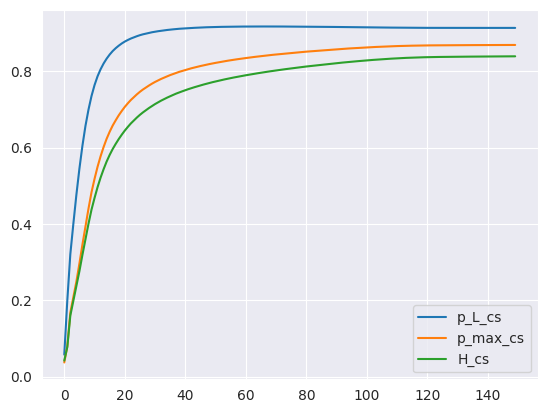

In [109]:
proxies = ["p_L_cs", "p_max_cs", "H_cs", "loss_cs"]

epoch_range = proxy_df["epoch"].unique()

fig, ax = plt.subplots()

for proxy in proxies:
    corrs = np.array([abs(calculate_spearmanr(proxy_df, epoch, proxy)) for epoch in epoch_range])
    ax.plot(epoch_range, corrs, label=proxy)

plt.legend()
plt.show()

In [116]:
from typing import Dict


class ProxyDataset:
    def __init__(self, proxy_dataset_path: os.PathLike):
        self.proxy_df = None
        self.proxy_dataset_path = proxy_dataset_path
        self.proxy_dataset = pq.ParquetDataset(proxy_dataset_path)

    def load(self, columns: list = None):
        self.proxy_df = self.proxy_dataset.read(columns=columns).to_pandas()
        self.proxy_df["epoch"] = self.proxy_df["epoch"].astype(int)

        return self.proxy_df

    def calculate_proxy_scores(self, proxy_name: str) -> Dict[int, float]:
        scores = self.proxy_df.groupby(["sample_indices"]).agg({proxy_name: "sum"})

        scores[proxy_name] = (scores[proxy_name] - scores[proxy_name].min()) / (
                    scores[proxy_name].max() - scores[proxy_name].min())

        return scores[proxy_name].to_dict()

In [124]:
proxy_ds = ProxyDataset("../models/proxies/speechcommands-m5-large-20230424_0751")
proxy_ds.load()

proxy_scores = proxy_ds.calculate_proxy_scores("p_max")

(array([  342.,   260.,   184.,   128.,    98.,   116.,   106.,    96.,
           99.,    88.,    87.,   111.,   121.,   114.,   137.,   135.,
          134.,   126.,   149.,   139.,   160.,   172.,   164.,   190.,
          192.,   206.,   268.,   284.,   308.,   303.,   331.,   350.,
          384.,   431.,   483.,   480.,   612.,   674.,   777.,   867.,
         1044.,  1159.,  1363.,  1630.,  2122.,  2949.,  4277.,  6923.,
        14755., 38215.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

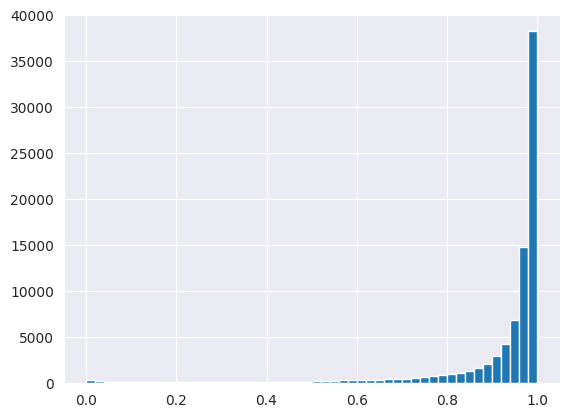

In [125]:
# plot the proxy score histogram

plt.hist(proxy_scores.values(), bins=50)